# Repare dataset

## txt2csv

In [1]:
import re
import csv

input_file = './dataset/ps_encodedcommand_data.txt'
output_file = './dataset/ps_encodedcommand_data.csv'

with open(input_file, 'rb') as file:
    content = file.read()

content_str = content.decode('latin-1')

pattern = re.compile(
        r'######################### START #########################(.*?)#########################  END  #########################',
    re.DOTALL
)

matches = pattern.findall(content_str)

data_list = []

for match in matches:
    original_code = re.search(r'\[Original Code\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    filename = re.search(r'\[Filename\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    arguments = re.search(r'\[Arguments\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    b64_decoded = re.search(r'\[B64 Decoded\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    family_name = re.search(r'\[Family Name\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()

    data = {
        'Original Code': original_code,
        'Filename': filename, 
        'Arguments': arguments,
        'B64 Decoded': b64_decoded,
        'Family Name': family_name
    }
    data_list.append(data)

with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Original Code', 'Filename', 'Arguments', 'B64 Decoded', 'Family Name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for data in data_list:
        writer.writerow(data)

print(f'Data has been written to {output_file}')

Data has been written to ./dataset/ps_encodedcommand_data.csv


## preprocess CSV

In [2]:
import pandas as pd
import re
from dataclasses import replace

input_file = './dataset/ps_encodedcommand_data.csv'
output_file = './dataset/data_processed.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

# print(df.head())

def extract_executable(input_string):
    pattern = re.compile(r'\\\"(.*?)\\\"|(\S+\.exe)|\bpowershell\b', re.IGNORECASE)
    match = pattern.search(input_string)
    if match:
        if match.group(1):
            result = match.group(1)
        elif match.group(2):
            result = match.group(2)
        else:
            result = match.group(0)
        result = result.replace('"', '')
        return result
    return None

# Áp dụng hàm extract_executable lên cột 'Original Code' và tạo cột mới 'Path Exec'
df['Path Exec'] = df['Original Code'].apply(extract_executable)

# print(df.head())

def combine_attributes(row):
    Path_Exec = str(row['Path Exec'])
    Arguments = re.sub(r"[\[\]',]", '', str(row['Arguments']))
    Payload = str(row['B64 Decoded'])

    combine_value = f'{Path_Exec} {Arguments} {Payload}'
    return combine_value

df['Full Payload'] = df.apply(combine_attributes, axis=1)

# print(df.head())

try:
    df.to_csv(output_file, index=False)
    print(f'DataFrame has been written to {output_file}')
except Exception as e:
    print(f'Error: {e}')

print(df['Family Name'].unique())

DataFrame has been written to ./dataset/data_processed.csv
['Shellcode Inject' 'Downloader DFSP' 'Powerfun Reverse' 'SET'
 'Downloader DFSP 2X' 'Unicorn' 'PowerShell Empire' 'Downloader Proxy'
 'Meterpreter RHTTP' 'Scheduled Task COM' 'Downloader IEXDS' 'Unknown'
 'AMSI Bypass' 'VB Task' 'Veil Stream' 'PowerWorm' 'Remote DLL'
 'Downloader Kraken' 'TXT C2' 'BITSTransfer' 'Downloader DFSP DPL'
 'Powerfun Bind' 'Unicorn Modified' 'PowerSploit GTS' 'DynAmite Launcher'
 'Remove AV' 'DynAmite KL']


## Combine Family name to label

In [3]:
import pandas as pd

input_file = './dataset/data_processed.csv'
output_file = './dataset/data_labeled.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

def map_family_to_label(family_name):
    if 'Bypass' in family_name or 'Remove AV' in family_name:
        return 'Bypass'
    elif 'Downloader' in family_name or 'Transfer' in family_name:
        return 'Downloader'
    elif 'Inject' in family_name or 'Trojan' in family_name or 'Unicorn' in family_name:
        return 'Injector'
    elif 'Power' in family_name or 'Empire' in family_name or 'Payload' in family_name:
        return 'Payload'
    elif 'Task' in family_name or 'COM' in family_name or 'Scheduled' in family_name:
        return 'TaskExecution'
    else:
        return 'Unknown'

df['Label'] = df['Family Name'].apply(map_family_to_label)
# print(df.head())

row_before = len(df)
df = df[df['Label'] != 'Unknown']
row_after = len(df)
row_removed = row_before - row_after
print(f'Number of rows removed: {row_removed}')

label_counts = df['Label'].value_counts()
print('Label counts:')
print(label_counts)

label_percentages = (label_counts / len(df)) * 100
print('Label percentages:')
print(label_percentages)

columns_to_keep = ['Full Payload', 'Label']
df = df[columns_to_keep]
df.to_csv(output_file, index=False)
print(f'DataFrame has been written to {output_file}')

Number of rows removed: 337
Label counts:
Label
Injector         1772
Downloader       1522
Payload           417
TaskExecution      21
Bypass             10
Name: count, dtype: int64
Label percentages:
Label
Injector         47.354356
Downloader       40.673437
Payload          11.143773
TaskExecution     0.561197
Bypass            0.267237
Name: count, dtype: float64
DataFrame has been written to ./dataset/data_labeled.csv


## Test

In [ ]:
import pandas as pd

input_file = './dataset/data_processed.csv'
output_file = './dataset/data_labeled.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

def map_family_to_label(family_name):
    if pd.isnull(family_name):
        return 'Unknown'

    family_name = family_name.lower()

    # Bypass
    if 'bypass' in family_name or 'remove av' in family_name:
        return 'Bypass'

    # TaskExecution
    elif 'task' in family_name or 'scheduled' in family_name or 'com' in family_name \
        or 'bits' in family_name or 'vb task' in family_name \
        or 'dynamite' in family_name:
        return 'TaskExecution'

    # Downloader
    elif 'downloader' in family_name or 'transfer' in family_name or 'proxy' in family_name \
        or 'iexds' in family_name or 'dfsp' in family_name:
        return 'Downloader'

    # Injector
    elif 'inject' in family_name or 'trojan' in family_name or 'shellcode' in family_name \
        or 'remote dll' in family_name or 'rhttp' in family_name \
        or ('unicorn' in family_name and 'modified' in family_name):
        return 'Injector'

    # Payload
    elif 'power' in family_name or 'empire' in family_name or 'veil' in family_name \
        or 'txt c2' in family_name or ('unicorn' in family_name and 'modified' not in family_name):
        return 'Payload'

    else:
        return 'Unknown'

# Gán nhãn
df['Label'] = df['Family Name'].apply(map_family_to_label)

# Loại bỏ 'Unknown'
row_before = len(df)
df = df[df['Label'] != 'Unknown']
row_after = len(df)
row_removed = row_before - row_after
print(f'Number of rows removed: {row_removed}')

# Thống kê số lượng nhãn
label_counts = df['Label'].value_counts()
print('Label counts:')
print(label_counts)

# Thống kê tỷ lệ phần trăm
label_percentages = (label_counts / len(df)) * 100
print('Label percentages:')
print(label_percentages)

# Lưu file
columns_to_keep = ['Full Payload', 'Label']
df = df[columns_to_keep]
df.to_csv(output_file, index=False)
print(f'DataFrame has been written to {output_file}')


## create short dataset for test

In [ ]:
# Test short

import pandas as pd

# Load dữ liệu full
df = pd.read_csv('./dataset/data_labeled.csv')

# Lấy theo yêu cầu
dfs = []

# Các lớp ít: giữ nguyên
dfs.append(df[df['Label'] == 'Bypass'])
dfs.append(df[df['Label'] == 'TaskExecution'])

# Các lớp nhiều: lấy random 50 mẫu
for label in ['Payload', 'Downloader', 'Injector']:
    sampled = df[df['Label'] == label].sample(n=50, random_state=42)
    dfs.append(sampled)

# Gộp lại
df_short = pd.concat(dfs).reset_index(drop=True)

# Shuffle để tránh các lớp liền kề
df_short = df_short.sample(frac=1, random_state=42).reset_index(drop=True)

# Lưu ra file
output_file_short = './dataset/data_labeled_short.csv'
df_short.to_csv(output_file_short, index=False)

print(f'Short dataset saved to {output_file_short}, total samples: {len(df_short)}')


Short dataset saved to ./dataset/data_labeled_short.csv, total samples: 181


# Extract vector

## rela2vec

In [4]:
# improve

import pandas as pd
import spacy
import networkx as nx
import pickle
from node2vec import Node2Vec
import numpy as np
import os

# Đường dẫn input và output
input_file = './dataset/data_labeled.csv'
output_graphs_file = './graph/semantic_graph.pkl'
output_vectors_file = './graph/semantic_graph_vectors.pkl'

# Tạo thư mục output nếu chưa có
os.makedirs('./graph', exist_ok=True)

# Load dataset
try:
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error reading CSV: {e}')
    exit()

# Khởi tạo SpaCy model
nlp = spacy.load("en_core_web_sm")

# Xử lý payloads
full_payloads = df['Full Payload'].dropna()
graphs = {}

# Xây dựng semantic graph cho từng payload
for idx, payload in enumerate(full_payloads):
    G = nx.Graph()
    doc = nlp(payload)

    # Thêm node từ entities
    for ent in doc.ents:
        G.add_node(ent.text, type=ent.label_)

    # Thêm cạnh giữa các entity trong cùng một câu
    for sent in doc.sents:
        entities_in_sentence = [ent.text for ent in sent.ents]
        for i in range(len(entities_in_sentence)):
            for j in range(i + 1, len(entities_in_sentence)):
                G.add_edge(entities_in_sentence[i], entities_in_sentence[j])

    graphs[idx] = G

# Lưu tất cả graphs
with open(output_graphs_file, 'wb') as f:
    pickle.dump(graphs, f)

print(f'Created {len(graphs)} graphs and saved to {output_graphs_file}')

# Khởi tạo dictionary lưu vector
graph_vectors = {}

# Chuyển mỗi graph thành vector bằng Node2Vec
for idx, G in graphs.items():
    if len(G.nodes) == 0:
        print(f"Graph {idx} is empty and will be skipped.")
        continue

    node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4, quiet=True)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    node_embeddings = model.wv
    graph_vector = np.mean([node_embeddings[node] for node in G.nodes], axis=0)

    graph_vectors[idx] = graph_vector

print(f"Converted {len(graph_vectors)} graphs to vectors.")

# Lưu tất cả vector vào file
with open(output_vectors_file, 'wb') as f:
    pickle.dump(graph_vectors, f)

print(f'Saved graph vectors to {output_vectors_file}')

# Kiểm tra nhanh
try: 
    with open(output_vectors_file, 'rb') as f:
        loaded_vectors = pickle.load(f)
except Exception as e:
    print(f'Error loading vector file: {e}')
    exit()

print(f'Number of graph vectors loaded: {len(loaded_vectors)}')

for i in range(min(5, len(loaded_vectors))):
    if i in loaded_vectors:
        vector = loaded_vectors[i]
        print(f"Graph {i} vector shape: {vector.shape}")
        print(f'First 10 elements of vector {i}: {vector[:10]}')
    else:
        print(f"Graph {i} not found in loaded_vectors.")


/home/mike/powershell_detection_multimodel_multioutput/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created 3742 graphs and saved to ./graph/semantic_graph.pkl


KeyboardInterrupt: 

### test

In [8]:
# extract_rela2vec_dataset_optimized.py

import pandas as pd
import spacy
import networkx as nx
import pickle
from node2vec import Node2Vec
import numpy as np
import os
from tqdm import tqdm

# ===== Config Paths =====
input_file = './dataset/data_labeled.csv'
output_graphs_file = './graph/semantic_graph.pkl'
output_vectors_pkl = './graph/semantic_graph_vectors.pkl'
output_vectors_csv = './dataset/rela2vec_dataset.csv'  # Xuất chuẩn Rela2Vec

# ===== Create Output Folders =====
os.makedirs('./graph', exist_ok=True)
os.makedirs('./dataset', exist_ok=True)

# ===== Load Dataset =====
try:
    df = pd.read_csv(input_file)
    print(f"✅ Loaded {len(df)} rows from {input_file}")
except Exception as e:
    print(f'❌ Error reading CSV: {e}')
    exit()

# ===== Initialize SpaCy Model =====
print("🚀 Loading SpaCy model (en_core_web_sm)...")
nlp = spacy.load("en_core_web_sm")  # Đầy đủ component để giữ độ chính xác

# ===== Build Semantic Graphs =====
print("🚀 Building semantic graphs...")
full_payloads = df['Full Payload'].dropna().tolist()
graphs = {}

for idx, doc in tqdm(enumerate(nlp.pipe(full_payloads, batch_size=32)), total=len(full_payloads)):
    G = nx.Graph()

    # Add nodes (entities)
    for ent in doc.ents:
        G.add_node(ent.text, type=ent.label_)

    # Add edges (entities co-occur in the same sentence)
    for sent in doc.sents:
        entities_in_sentence = [ent.text for ent in sent.ents]
        for i in range(len(entities_in_sentence)):
            for j in range(i + 1, len(entities_in_sentence)):
                G.add_edge(entities_in_sentence[i], entities_in_sentence[j])

    graphs[idx] = G

print(f"✅ Created {len(graphs)} graphs.")

# ===== Save Semantic Graphs =====
with open(output_graphs_file, 'wb') as f:
    pickle.dump(graphs, f)
print(f"✅ Saved semantic graphs to {output_graphs_file}")

# ===== Generate Graph Vectors (Optimized) =====
print("🚀 Generating graph vectors (Optimized Node2Vec)...")

graph_vectors = {}

for idx, G in tqdm(graphs.items()):
    if len(G.nodes) == 0:
        continue

    node2vec = Node2Vec(
        G, 
        dimensions=128, 
        walk_length=30, 
        num_walks=100,  # Giảm từ 200 -> 100 để tăng tốc mà vẫn giữ chính xác
        workers=16,
        quiet=True
    )
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    node_embeddings = model.wv
    graph_vector = np.mean([node_embeddings[node] for node in G.nodes], axis=0)

    graph_vectors[idx] = graph_vector

print(f"✅ Generated {len(graph_vectors)} graph vectors.")

# ===== Save Graph Vectors to Pickle =====
with open(output_vectors_pkl, 'wb') as f:
    pickle.dump(graph_vectors, f)
print(f"✅ Saved graph vectors to {output_vectors_pkl}")

# ===== Save Graph Vectors to CSV (rela2vec format) =====
print("🚀 Preparing CSV output (Payload, Label, Rela2Vec)...")

rows = []

for idx, vector in graph_vectors.items():
    if idx >= len(df):
        continue

    payload = df.loc[idx, 'Full Payload']
    label = df.loc[idx, 'Label'] if 'Label' in df.columns else df.loc[idx, 'Family Name']

    vec_str = ' '.join(map(str, vector))

    rows.append({
        'Payload': payload,
        'Label': label,
        'Rela2Vec': vec_str
    })

rela2vec_df = pd.DataFrame(rows)
rela2vec_df.to_csv(output_vectors_csv, index=False)

print(f"✅ Saved rela2vec dataset to {output_vectors_csv}")

# ===== Quick Sample Check =====
print("\n=== Quick Sample Check ===")
for i in range(min(5, len(graph_vectors))):
    if i in graph_vectors:
        vec = graph_vectors[i]
        print(f"Graph {i}: vector shape = {vec.shape}, first 10 elements = {vec[:10]}")


✅ Loaded 3742 rows from ./dataset/data_labeled.csv
🚀 Loading SpaCy model (en_core_web_sm)...
🚀 Building semantic graphs...


100%|██████████| 3742/3742 [00:23<00:00, 161.09it/s]


✅ Created 3742 graphs.
✅ Saved semantic graphs to ./graph/semantic_graph.pkl
🚀 Generating graph vectors (Optimized Node2Vec)...


100%|██████████| 3742/3742 [48:43<00:00,  1.28it/s]  


✅ Generated 3733 graph vectors.
✅ Saved graph vectors to ./graph/semantic_graph_vectors.pkl
🚀 Preparing CSV output (Payload, Label, Rela2Vec)...
✅ Saved rela2vec dataset to ./dataset/rela2vec_dataset.csv

=== Quick Sample Check ===
Graph 0: vector shape = (128,), first 10 elements = [-0.11079321 -0.01667273  0.22461937 -0.09103265 -0.07140967 -0.22882429
 -0.07363412  0.0549212  -0.0468871   0.0266804 ]
Graph 1: vector shape = (128,), first 10 elements = [-0.00041893  0.00018471  0.00398699  0.00703849 -0.00726793 -0.00556001
  0.00504599  0.00701015 -0.0039183  -0.00294013]
Graph 2: vector shape = (128,), first 10 elements = [-0.09075686 -0.00335437  0.08056004 -0.07280748 -0.02079524 -0.11253942
 -0.04730597  0.0315416  -0.00417314  0.02840811]
Graph 3: vector shape = (128,), first 10 elements = [-0.00107376  0.00068332  0.00224154  0.00024206 -0.00146175 -0.00431028
  0.00486663  0.00346188 -0.00139757  0.0030655 ]
Graph 4: vector shape = (128,), first 10 elements = [ 0.09866986 -0.

## char2vec

In [9]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import os
import pickle

def generate_char2vec_csv(input_csv, output_csv, column_name='Full Payload', label_column='Label', vector_size=128, window=5, min_count=1, workers=4):
    model_path = './graph/char2vec.model'
    df = pd.read_csv(input_csv)
    
    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    sentences = [list(str(code)) for code in df[column_name] if isinstance(code, str)]

    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"Đã huấn luyện xong Char2Vec với {len(model.wv.index_to_key)} ký tự.")

    model.save(model_path)
    print(f"Đã lưu model tại {model_path}")
    
    with open('./graph/char2vec.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("Đã lưu model pickle tại ./graph/char2vec.pkl")

    rows = []

    for idx, row in df.iterrows():
        payload = row[column_name]
        label = row[label_column]

        if not isinstance(payload, str):
            continue  # Nếu payload không phải chuỗi, bỏ qua

        # Vector trung bình các ký tự trong payload
        vectors = [model.wv[char] for char in list(payload) if char in model.wv]
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
        else:
            avg_vector = np.zeros(vector_size)

        # Convert vector thành chuỗi để lưu CSV
        vec_str = ' '.join(map(str, avg_vector))

        rows.append({
            'ID': idx,
            'Payload': payload,
            'Label': label,
            'Char2Vec': vec_str
        })

    # Tạo DataFrame và lưu CSV
    output_df = pd.DataFrame(rows)
    output_df.to_csv(output_csv, index=False)
    print(f"Đã lưu {len(output_df)} dòng vào file {output_csv}")

# ===========================
# Ví dụ sử dụng:
input_csv = './dataset/data_labeled.csv'
output_csv = './dataset/char2vec_dataset.csv'

generate_char2vec_csv(input_csv, output_csv)


Đã huấn luyện xong Char2Vec với 98 ký tự.
Đã lưu model tại ./graph/char2vec.model
Đã lưu model pickle tại ./graph/char2vec.pkl
Đã lưu 3742 dòng vào file ./dataset/char2vec_dataset.csv


## token2vec

In [11]:
import pandas as pd
import numpy as np
import os
import re
from gensim.models import Word2Vec

# ===== Helper functions =====

def extract_token(script):
    cmdlets = re.findall(r'\b(?:Invoke-Expression|Invoke-Command|Start-Process|New-Object|Set-ExecutionPolicy|Get-Content|Add-Type|Invoke-WebRequest|Invoke-RestMethod|Get-WmiObject|Out-File|New-Service|Remove-Item)\b', script)
    variables = re.findall(r'\$[a-zA-Z_][\w]*', script)
    functions = re.findall(r'\bfunction\s+\w+', script)
    keywords = re.findall(r'\b(?:if|else|for|while|return)\b', script)
    parameters = re.findall(r'-\w+', script)
    strings = re.findall(r'".+?"', script)
    return cmdlets + variables + functions + keywords + parameters + strings

def token2vec_for_column(df, column_name='Full Payload', vector_size=128, window=5, min_count=1, workers=4):
    token_lists = [extract_token(script) for script in df[column_name].astype(str)]

    model = Word2Vec(token_lists, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"Đã train xong Token2Vec model với {len(model.wv.index_to_key)} tokens.")

    # Save model
    os.makedirs('./token2vec', exist_ok=True)
    model_path = f'./token2vec/{column_name}_token2vec.model'
    model.save(model_path)
    print(f"Đã lưu model tại {model_path}")

    return model, token_lists

def generate_token2vec_csv(df, token_lists, model, output_csv, column_name='Full Payload', label_column='Label', vector_size=128):
    # Sinh vector trung bình cho mỗi payload
    payload_vectors = [
        np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0) if tokens else np.zeros(vector_size)
        for tokens in token_lists
    ]

    # Tạo DataFrame mới
    output_df = pd.DataFrame({
        'Payload': df[column_name],
        'Label': df[label_column],
        'Token2Vec': [' '.join(map(str, vec)) for vec in payload_vectors]
    })

    # Lưu ra CSV
    output_df.to_csv(output_csv, index=False)
    print(f"Đã lưu {len(output_df)} dòng vào file {output_csv}")

# ===== Main processing =====

input_file = './dataset/data_labeled.csv'
output_csv = './dataset/token2vec_dataset.csv'

# Load dataset
try:
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error reading CSV: {e}')
    exit()

# Gọi hàm xử lý
token2vec_model, token_lists = token2vec_for_column(df, column_name='Full Payload')

# Sinh và lưu dataset
generate_token2vec_csv(df, token_lists, token2vec_model, output_csv)

print("✅ Xử lý hoàn tất!")


Đã train xong Token2Vec model với 1658 tokens.
Đã lưu model tại ./token2vec/Full Payload_token2vec.model
Đã lưu 3742 dòng vào file ./dataset/token2vec_dataset.csv
✅ Xử lý hoàn tất!


## ast2vec

In [12]:
import re
import os
import pickle
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from anytree import Node

# ===== Helper Classes and Functions =====

class EnhancedPowerShellASTParser:
    def __init__(self, code):
        self.code = code
        self.root = Node("Root")

    def parse_code(self):
        tokens = re.findall(r'\b\w+\b', self.code)
        current_node = self.root
        for token in tokens:
            if token.lower() in ["function", "if", "foreach", "while", "try", "catch"]:
                Node(f"{token.capitalize()}Statement", parent=current_node)
            elif token.lower() in ["param", "return"]:
                Node("ParameterStatement", parent=current_node)
            elif token.lower() == "pipeline":
                Node("Pipeline", parent=current_node)
            elif token.lower() in ["cmdlet", "assignment"]:
                Node(f"{token.capitalize()}Node", parent=current_node)
            else:
                Node(token, parent=current_node)
        return self.root

    def postorder_traversal(self, node):
        sequence = []
        for child in node.children:
            sequence.extend(self.postorder_traversal(child))
        sequence.append(node.name)
        return sequence

def build_feature_set_from_ast(ast_sequences):
    unique_features = set()
    for seq in ast_sequences:
        unique_features.update(seq)
    return list(unique_features)

def calculate_word_vectors(features, vector_size=128, window=5, min_count=1):
    model = Word2Vec(sentences=features, vector_size=vector_size, window=window, min_count=min_count)
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
    return word_vectors

def generate_ast_embedding(ast_sequence, word_vectors, vector_size=128):
    vectors = [word_vectors[token] for token in ast_sequence if token in word_vectors]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# ===== Main Processing =====

input_file = './dataset/data_labeled.csv'
output_csv = './dataset/ast2vec_dataset.csv'

# Load dataset
try:
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error reading CSV: {e}')
    exit()

# Parse AST và sinh sequence cho mỗi script
ast_sequences = []
for script in df['Full Payload']:
    parser = EnhancedPowerShellASTParser(script)
    ast_tree = parser.parse_code()
    sequence = parser.postorder_traversal(ast_tree)
    ast_sequences.append(sequence)

# Huấn luyện Word2Vec
features = build_feature_set_from_ast(ast_sequences)
word_vectors = calculate_word_vectors(ast_sequences)

# Sinh ast2vec embedding
ast_embeddings = [generate_ast_embedding(seq, word_vectors) for seq in ast_sequences]
df['Ast2Vec'] = ast_embeddings

# Save ast2vec dataset
output_df = pd.DataFrame({
    'Payload': df['Full Payload'],
    'Label': df['Label'],  # Hoặc 'Family Name' nếu đúng tên cột
    'Ast2Vec': [' '.join(map(str, vec)) for vec in ast_embeddings]
})

output_df.to_csv(output_csv, index=False)
print(f"Đã lưu {len(output_df)} dòng vào file {output_csv}")

# Save ast2vec Word2Vec model
os.makedirs('./ast2vec', exist_ok=True)
with open('./ast2vec/ast2vec_model.pkl', 'wb') as f:
    pickle.dump(word_vectors, f)
print("✅ Mô hình ast2vec đã được lưu thành công!")


Đã lưu 3742 dòng vào file ./dataset/ast2vec_dataset.csv
✅ Mô hình ast2vec đã được lưu thành công!


# processing and model training

## combine csv include 4 vector

In [13]:
import pandas as pd
import numpy as np
import os

# ===== Config paths =====

char2vec_csv = './dataset/char2vec_dataset.csv'
token2vec_csv = './dataset/token2vec_dataset.csv'
rela2vec_csv = './dataset/rela2vec_dataset.csv'
ast2vec_csv = './dataset/ast2vec_dataset.csv'
fusion_all_csv = './dataset/fusion_all.csv'

# ===== Load datasets =====

try:
    df_char = pd.read_csv(char2vec_csv)
    df_token = pd.read_csv(token2vec_csv)
    df_rela = pd.read_csv(rela2vec_csv)
    df_ast = pd.read_csv(ast2vec_csv)
except Exception as e:
    print(f"Lỗi khi load file CSV: {e}")
    exit()

print("✅ Đã load xong 4 file CSV.")

# ===== Tạo từ điển ánh xạ Payload → Vector =====

# Tạo mapping từ Payload sang vector
token_map = dict(zip(df_token['Payload'], df_token['Token2Vec']))
rela_map = dict(zip(df_rela['Payload'], df_rela['Rela2Vec']))
ast_map = dict(zip(df_ast['Payload'], df_ast['Ast2Vec']))

print("✅ Đã tạo mapping Payload → Vector cho token, rela, ast.")

# ===== Gộp thông tin =====

rows = []
missing_count = 0

for idx, row in df_char.iterrows():
    payload = row['Payload']
    label = row['Label']
    char_vec = row['Char2Vec']

    # Lấy vector từ các bảng còn lại
    token_vec = token_map.get(payload)
    rela_vec = rela_map.get(payload)
    ast_vec = ast_map.get(payload)

    # Nếu thiếu bất kỳ vector nào → bỏ qua
    if token_vec is None or rela_vec is None or ast_vec is None:
        missing_count += 1
        continue

    rows.append({
        'Payload': payload,
        'Label': label,
        'Char2Vec': char_vec,
        'Token2Vec': token_vec,
        'Rela2Vec': rela_vec,
        'Ast2Vec': ast_vec
    })

print(f"✅ Tổng payload đầy đủ vector: {len(rows)}")
print(f"⚠️ Bỏ qua {missing_count} payload do thiếu vector.")

# ===== Lưu kết quả =====

fusion_df = pd.DataFrame(rows)
os.makedirs('./dataset', exist_ok=True)
fusion_df.to_csv(fusion_all_csv, index=False)

print(f"✅ Đã lưu file gộp đầy đủ Payload, Label và 4 loại vector vào {fusion_all_csv}")


✅ Đã load xong 4 file CSV.
✅ Đã tạo mapping Payload → Vector cho token, rela, ast.
✅ Tổng payload đầy đủ vector: 3733
⚠️ Bỏ qua 9 payload do thiếu vector.
✅ Đã lưu file gộp đầy đủ Payload, Label và 4 loại vector vào ./dataset/fusion_all.csv


## fussion to 1 vector

In [14]:
import pandas as pd
import numpy as np
import os

# ===== Config paths =====

fusion_all_csv = './dataset/fusion_all.csv'
fusion_with_vector_csv = './dataset/fusion_with_vector.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(fusion_all_csv)
except Exception as e:
    print(f"Lỗi khi load fusion_all.csv: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {fusion_all_csv}")

# ===== Parse các vector từ chuỗi sang numpy array =====

def parse_vector_string(vec_string):
    try:
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"Error parsing vector: {e}")
        return np.zeros(128)  # fallback nếu lỗi

df['Char2Vec_array'] = df['Char2Vec'].apply(parse_vector_string)
df['Token2Vec_array'] = df['Token2Vec'].apply(parse_vector_string)
df['Rela2Vec_array'] = df['Rela2Vec'].apply(parse_vector_string)
df['Ast2Vec_array'] = df['Ast2Vec'].apply(parse_vector_string)

print("✅ Đã parse các vector thành np.array.")

# ===== Gộp fusion_vector chuẩn 512 chiều =====

def fuse_vectors(row):
    return np.concatenate([row['Char2Vec_array'], row['Token2Vec_array'], row['Rela2Vec_array'], row['Ast2Vec_array']])

df['FusionVector'] = df.apply(fuse_vectors, axis=1)

print("✅ Đã thêm cột FusionVector với 512 chiều.")

# ===== Lưu file mới =====

# Convert FusionVector thành chuỗi trước khi lưu
df['FusionVector'] = df['FusionVector'].apply(lambda vec: ' '.join(map(str, vec)))

# Lưu toàn bộ DataFrame (KHÔNG bỏ cột nào)
os.makedirs('./dataset', exist_ok=True)
df.to_csv(fusion_with_vector_csv, index=False)

print(f"✅ Đã lưu file đầy đủ vào {fusion_with_vector_csv}")


✅ Đã load 3733 dòng từ ./dataset/fusion_all.csv
✅ Đã parse các vector thành np.array.
✅ Đã thêm cột FusionVector với 512 chiều.
✅ Đã lưu file đầy đủ vào ./dataset/fusion_with_vector.csv


## load and split

✅ Đã load 3733 dòng từ ./dataset/fusion_with_vector.csv
✅ Đã parse FusionVector thành np.array.
✅ X có shape (3733, 512)
✅ y có shape (3733,)
✅ Đã one-hot encode Label thành shape (3733, 5)
✅ X sau reshape có shape (3733, 512, 1)
✅ Đã chia dữ liệu: Train 2986 samples, Test 747 samples.


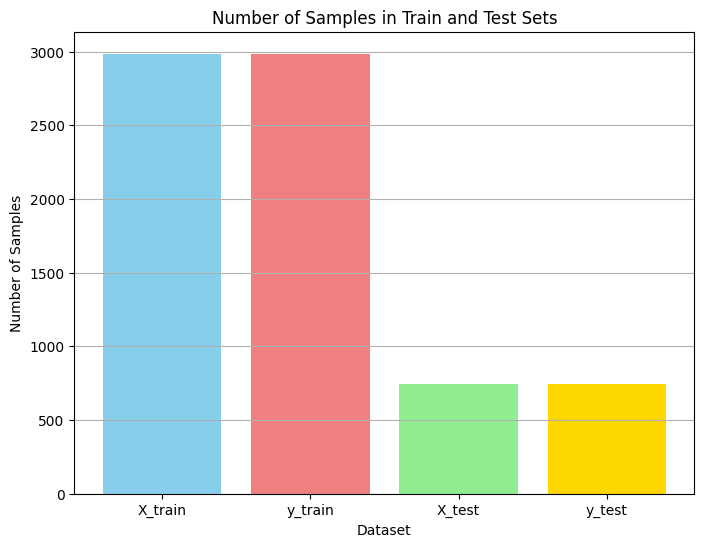

====== FINAL CHECK ======
Type X_train: <class 'numpy.ndarray'>, shape: (2986, 512, 1)
Type y_train: <class 'numpy.ndarray'>, shape: (2986, 5)
Type X_test: <class 'numpy.ndarray'>, shape: (747, 512, 1)
Type y_test: <class 'numpy.ndarray'>, shape: (747, 5)


In [15]:
# prepare_data_for_training.py

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# ===== Config paths =====

fusion_with_vector_csv = './dataset/fusion_with_vector.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(fusion_with_vector_csv)
except Exception as e:
    print(f"Lỗi khi load fusion_with_vector.csv: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {fusion_with_vector_csv}")

# ===== Parse FusionVector từ chuỗi sang np.array =====

def parse_fusion_vector(vec_string):
    try:
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"Error parsing fusion vector: {e}")
        return np.zeros(512)  # fallback nếu lỗi

df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

print("✅ Đã parse FusionVector thành np.array.")

# ===== Chuẩn bị X, y =====

# X là FusionVector, y là Label
X = np.stack(df['FusionVector_array'].values)
y_labels = df['Label'].values

print(f"✅ X có shape {X.shape}")
print(f"✅ y có shape {y_labels.shape}")

# ===== One-hot encode Label =====

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

print(f"✅ Đã one-hot encode Label thành shape {y.shape}")

# ===== Reshape X cho CNN/BiLSTM =====

# Reshape (batch_size, 512, 1) cho 1D CNN hoặc BiLSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"✅ X sau reshape có shape {X.shape}")

# ===== Split train/test =====

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Đã chia dữ liệu: Train {X_train.shape[0]} samples, Test {X_test.shape[0]} samples.")

# ===== Visualization: Số lượng mẫu train/test =====

# Data for bar chart
data = {
    'Dataset': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of Samples': [X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]]
}

df_vis = pd.DataFrame(data)

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_vis['Dataset'], df_vis['Number of Samples'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Train and Test Sets')
plt.grid(axis='y')
plt.show()

# ===== In lại kiểm tra cuối =====

print("====== FINAL CHECK ======")
print(f"Type X_train: {type(X_train)}, shape: {X_train.shape}")
print(f"Type y_train: {type(y_train)}, shape: {y_train.shape}")
print(f"Type X_test: {type(X_test)}, shape: {X_test.shape}")
print(f"Type y_test: {type(y_test)}, shape: {y_test.shape}")


## train and evaluate model

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5001 - loss: 1.5498 - val_accuracy: 0.9833 - val_loss: 0.4236
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9600 - loss: 0.3997 - val_accuracy: 0.9732 - val_loss: 0.3482
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9776 - loss: 0.3031 - val_accuracy: 0.9783 - val_loss: 0.2738
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9815 - loss: 0.2651 - val_accuracy: 0.9950 - val_loss: 0.2028
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9675 - loss: 0.2778 - val_accuracy: 0.9916 - val_loss: 0.1903
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9876 - loss: 0.2041 - val_accuracy: 0.9783 - val_loss: 0.2681
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9319 - loss: 0.4463 - val_accuracy: 0.9916 - val_loss: 0.2063
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9892 - loss: 0.2138 - val_accuracy: 0.9933 - v

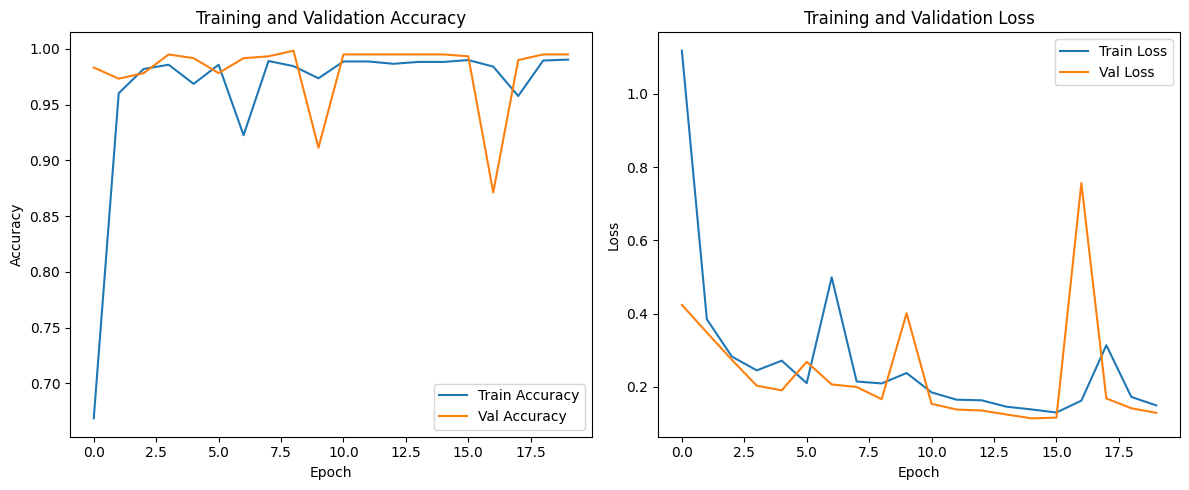

In [17]:
# ====== train_cnn_bilstm_attention.py ======

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels

# ===== Config =====
INPUT_SHAPE = (512, 1)   # Vì fusion vector có 512 chiều
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
LEARNING_RATE = 1e-3

# ===== Build Model =====
def build_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    input_layer = Input(shape=input_shape)

    x = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))(x)

    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ===== Train Model =====
def train_model(model, X_train, y_train):
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stop],
                        verbose=1)
    return history

# ===== Evaluate Model =====
def evaluate_model(model, X_test, y_test, target_names):
    print("\n=== Evaluating Model ===")

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    if y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    precision = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    acc = accuracy_score(y_test_labels, y_pred_labels)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

    print("\n=== Classification Report ===")
    labels_in_test = sorted(list(unique_labels(y_test_labels, y_pred_labels)))
    target_names_subset = [target_names[i] for i in labels_in_test]
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_names_subset, digits=4, zero_division=0))

# ===== Plot Training Curves =====
def plot_training_curves(history):
    print("\n=== Plotting Training Curves ===")
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ===== Main Process =====
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('./dataset/fusion_with_vector.csv')

    def parse_fusion_vector(vec_string):
        return np.fromstring(vec_string, sep=' ')

    df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

    X = np.stack(df['FusionVector_array'].values)
    y_labels = df['Label'].values

    lb = LabelBinarizer()
    y = lb.fit_transform(y_labels)

    X = X.reshape(X.shape[0], X.shape[1], 1)

    # --- Chia train/test có stratify để không mất lớp nhỏ ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)

    target_names = lb.classes_.tolist()

    # Build, Train, Evaluate
    model = build_model()
    history = train_model(model, X_train, y_train)
    evaluate_model(model, X_test, y_test, target_names)
    plot_training_curves(history)
